In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

from os import listdir
from os.path import isfile, join
import random, warnings

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2, tensorflow.keras, tensorflow.keras.utils
import sys, argparse, json, operator

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import mobilenet
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.utils.data_utils import get_file

import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report

In [ ]:
def PicAugmentation(path, num_aug):
    # num_aug decides the amount of augmented images and the total images will be (num_aug*3+1) times of original datasets
    # In this code, our datasets included 338 images and were augmeted 40 times
    IMG_W, IMG_H = 224, 224
    batch_size, iteration = 338, num_aug
    generator = ImageDataGenerator(rescale = 1./255)
    obj0 = generator.flow_from_directory(path,
                                    target_size = (IMG_W,IMG_H),
                                    batch_size=batch_size,
                                    class_mode='categorical')
    img0, label0 = obj0.next()
    
    generator = ImageDataGenerator(
                                rotation_range = 20,
                                width_shift_range = 0.0,
                                height_shift_range = 0.0,
                                rescale = 1./255)
    obj = generator.flow_from_directory(path,
                                        target_size = (IMG_W,IMG_H),
                                        batch_size=batch_size,
                                        class_mode='categorical')
    for i in range(iteration):
        img, label = obj.next()
        img0 = np.append(img0, img, axis=0)
        label0 = np.append(label0, label, axis=0)
    print('Rotation Clear')
    print(img0.shape)
    print(label0.shape)

    generator = ImageDataGenerator(
                                rotation_range = 0,
                                width_shift_range = 0.2,
                                height_shift_range = 0.0,
                                rescale = 1./255)
    obj2 = generator.flow_from_directory(path,
                                        target_size = (IMG_W,IMG_H),
                                        batch_size=batch_size,
                                        class_mode='categorical')
    for i in range(iteration):
        img2, label2 = obj2.next()
        img0 = np.append(img0, img2, axis=0)
        label0 = np.append(label0, label2, axis=0)
        
    print('Width Shift Clear')
    print(img0.shape)
    print(label0.shape)
        
    generator = ImageDataGenerator(
                                rotation_range = 0,
                                width_shift_range = 0.0,
                                height_shift_range = 0.2,
                                rescale = 1./255)
    obj3 = generator.flow_from_directory(path,
                                        target_size = (IMG_W,IMG_H),
                                        batch_size=batch_size,
                                        class_mode='categorical')
    for i in range(iteration):
        img3, label3 = obj3.next()
        img0 = np.append(img0, img3, axis=0)
        label0 = np.append(label0, label3, axis=0)
    
    print('Height Shift Clear')
    print(img0.shape)
    print(label0.shape)
    return img0, label0

In [ ]:
basePath = r'C:\Users\dell\new_kdy_3' # customize your location
iteration = 13
img, label = PicAugmentation(basePath, 13)

train_images,test_images,train_labels,test_labels=train_test_split(img,label,test_size=0.2, random_state=99)
datagen = ImageDataGenerator(
        horizontal_flip=True,
        fill_mode='nearest')
datagen.fit(train_images)

In [ ]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()
base_model = MobileNet(weights='imagenet', include_top=False, dropout=0.25, alpha=1.0, input_shape=(IMG_W,IMG_H,3))
num_classes = 16 # the number of labels

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
pred_x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=pred_x)

for layer in model.layers[:-5]:
    layer.trainable=False
for layer in model.layers[-5:]:
    layer.trainable=True

model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),\
              loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
batch_size = 64
epochs = 100
History = model.fit_generator(
            datagen.flow(train_images,train_labels, batch_size=batch_size),
            steps_per_epoch=train_images.shape[0] // batch_size,
            epochs = epochs,
            validation_data = (test_images,test_labels))

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
169/169 [==============================] - 21s 122ms/step - loss: 0.3910 - accuracy: 0.8822 - val_loss: 0.0515 - val_accuracy: 0.9848
Epoch 2/100
169/169 [==============================] - 18s 107ms/step - loss: 0.0194 - accuracy: 0.9945 - val_loss: 0.2371 - val_accuracy: 0.9275
Epoch 3/100
169/169 [==============================] - 18s 104ms/step - loss: 0.0248 - accuracy: 0.9923 - val_loss: 0.1094 - val_accuracy: 0.9645
Epoch 4/100
169/169 [==============================] - 18s 104ms/step - loss: 0.0316 - accuracy: 0.9925 - val_loss: 0.1104 - val_accuracy: 0.9586
Epoch 5/100
169/169 [==============================] - 18s 106ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0991 - val_accuracy: 0.9660
Epoch 6/100
169/169 [==============================] - 18s 106ms/step - loss: 0.0243 - accuracy: 0.9914 - val_loss: 0.0609 - val_accuracy: 0.9793
Epoch 7/100
169/169 [=========

Epoch 54/100
169/169 [==============================] - 18s 106ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.1043 - val_accuracy: 0.9767
Epoch 55/100
169/169 [==============================] - 18s 106ms/step - loss: 1.6238e-04 - accuracy: 1.0000 - val_loss: 0.0928 - val_accuracy: 0.9800
Epoch 56/100
169/169 [==============================] - 18s 107ms/step - loss: 1.7000e-04 - accuracy: 0.9999 - val_loss: 0.0790 - val_accuracy: 0.9804
Epoch 57/100
169/169 [==============================] - 18s 107ms/step - loss: 0.0193 - accuracy: 0.9969 - val_loss: 0.1014 - val_accuracy: 0.9793
Epoch 58/100
169/169 [==============================] - 18s 106ms/step - loss: 5.3546e-04 - accuracy: 0.9998 - val_loss: 0.0827 - val_accuracy: 0.9848
Epoch 59/100
169/169 [==============================] - 18s 106ms/step - loss: 2.1087e-05 - accuracy: 1.0000 - val_loss: 0.0810 - val_accuracy: 0.9852
Epoch 60/100
169/169 [==============================] - 18s 107ms/step - loss: 5.5535e-04 - accuracy: 

In [9]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.020928454037955135
Test accuracy: 0.99556214


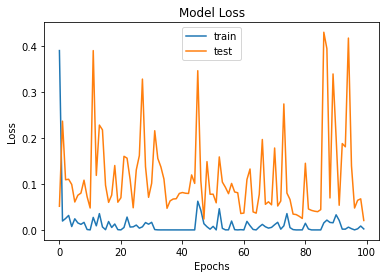

In [10]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

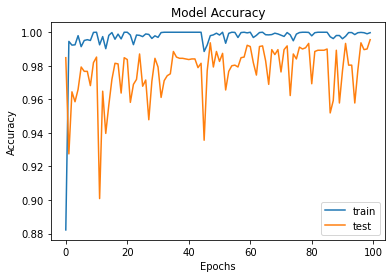

In [11]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [12]:
pred=model.predict(test_images)
pred_digits=np.argmax(pred,axis=1)
pred_Y = to_categorical(pred_digits,16)

print(classification_report(test_labels,pred_Y))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       164
           1       1.00      0.97      0.98       164
           2       0.99      1.00      1.00       164
           3       1.00      0.99      1.00       192
           4       1.00      1.00      1.00       160
           5       0.99      1.00      1.00       162
           6       1.00      0.99      1.00       142
           7       1.00      0.99      0.99       148
           8       1.00      0.99      1.00       171
           9       0.98      1.00      0.99       196
          10       1.00      1.00      1.00       161
          11       0.98      1.00      0.99       175
          12       1.00      1.00      1.00       162
          13       1.00      1.00      1.00       198
          14       1.00      1.00      1.00       163
          15       0.98      1.00      0.99       182

   micro avg       1.00      1.00      1.00      2704
   macro avg       1.00   

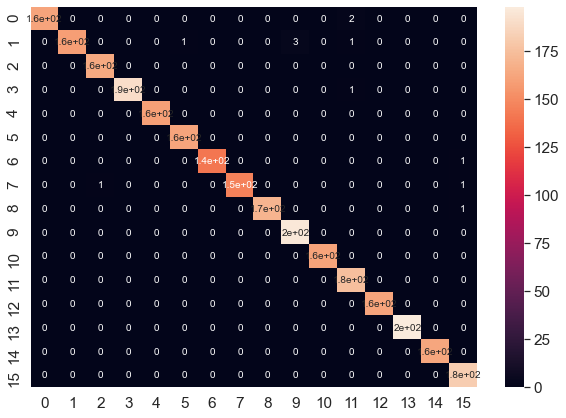

In [13]:
real_Y = np.argmax(test_labels, axis=1, out=None)
cnf_matrix = confusion_matrix(real_Y, pred_digits)

df_cm = pd.DataFrame(cnf_matrix, range(16), range(16))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
plt.show()